## A jupyter notebook to plot a graph depicting the salinecy maps of an already trained model

This notebook will follow (somewhat) the steps described in the following paper (https://arxiv.org/abs/1506.01066) and tutorial (https://discuss.pytorch.org/t/how-to-plot-saliency-map-from-rnn-model-in-nlp-task/82338)

In [71]:
""" 

https://github.com/amdreamer/Machine-Learning-Programs/blob/master/l3-textClassification_embedOutOfModel.py#L164

https://discuss.pytorch.org/t/how-to-plot-saliency-map-from-rnn-model-in-nlp-task/82338

https://www.quora.com/How-is-a-saliency-map-generated-when-training-recurrent-neural-networks-with-soft-attention
"""

' \n\nhttps://github.com/amdreamer/Machine-Learning-Programs/blob/master/l3-textClassification_embedOutOfModel.py#L164\n\nhttps://discuss.pytorch.org/t/how-to-plot-saliency-map-from-rnn-model-in-nlp-task/82338\n\nhttps://www.quora.com/How-is-a-saliency-map-generated-when-training-recurrent-neural-networks-with-soft-attention\n'

In [72]:
# https://github.com/amdreamer/Machine-Learning-Programs/blob/master/l3-textClassification_embedOutOfModel.py
# https://discuss.pytorch.org/t/how-to-plot-saliency-map-from-rnn-model-in-nlp-task/82338
# https://arxiv.org/abs/1506.01066

#! DISCLAIMER: For these following imports, you have to add the following node to the VSCode settings.json file:
# "jupyter.notebookFileRoot": "${workspaceFolder}",

# import the necessary functions RNNModelTrain module
from src.RNNModelTrain.utils import load_model, set_seed

# Imports
import numpy as np
import pandas as pd
from typing import List
from collections import OrderedDict

import torch
from torch.jit import RecursiveScriptModule
from torch.nn.functional import sigmoid
from torch.nn.utils.rnn import pad_sequence


# other libraries
from typing import Final

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# own modules
from src.model_utils import set_seed
from src.model_utils import load_model
from src.model_utils import predict_single_text_DE
from src.model_utils import word2idx
from src.model_utils import load_w2v_model
from src.model_utils import tokenize_sentence
from src.model_utils import tokenize_tweet

%matplotlib inline


Notebook setup

In [73]:
# static variables
DATA_PATH: Final[str] = "NLP_Data/data"
MODEL_TYPE: Final[str] = "IMDB"  # "TweepFake"

# set device
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
set_seed(42)

In [74]:
# load the model
print("Loading model...")
if MODEL_TYPE == "IMDB":
    model: RecursiveScriptModule = load_model("IMDB_DE_best_model")
else:
    model: RecursiveScriptModule = load_model("best_model")
    
print("Loading embeddings...")
# Load the w2v model
w2vec_model = load_w2v_model()

embedding_weights = torch.FloatTensor(w2vec_model.vectors)
embedding = torch.nn.Embedding.from_pretrained(embedding_weights)


Loading model...
Loading embeddings...


In [75]:
model

RecursiveScriptModule(
  original_name=RNNModel
  (rnn): RecursiveScriptModule(original_name=RNN)
  (fc): RecursiveScriptModule(original_name=Linear)
)

In [76]:
if MODEL_TYPE == "IMDB":
    file_path = DATA_PATH + '/test.txt'
    data: pd.DataFrame = pd.read_csv(file_path, sep='\t', header=None)
    data.columns = ['text', 'tag']

else:
    file_path = DATA_PATH + '/test.csv'
    data: pd.DataFrame = pd.read_csv(file_path)

    # replace the target column with a binary representation
    data['tag'] = data['account.type'].replace('human', 0)
    data['tag'] = data['tag'].replace('bot', 1)
    # Only keep columns text and tag
    data = data[['text', 'tag']]

print(data.head())

                                                text  tag
0  I first saw The Buddy Holly Story when I was a...    1
1  There were so many things wrong with this movi...    0
2  There's a unique place in the pantheon of John...    1
3  It kicks you in the stomach. There are other f...    1
4  To start, I'm not a person to rate movies that...    0


In [77]:
# Test the model with a single text
text = data['text'][2]
print(text)
predicted = predict_single_text_DE(text, model, embedding, device, model_type=MODEL_TYPE)
print(f"Predicted: {predicted}, Real: {data['tag'][0]}")

There's a unique place in the pantheon of John Ford films for Wagonmaster, Sergeant Rutledge, and The Sun Shines Bright. It was these three films with no box office names in them that Ford didn't have to tailor the film around the persona of a star being it John Wayne, Henry Fonda, or any of the others he worked with. Not surprising that Ford considered all these as favorites of one kind or another. <br /><br />Ben Johnson and Harry Carey, Jr. a couple of likable cowpokes sign on to guide a Mormon wagon train to a valley in Arizona territory. Along the way they are joined first by a group stranded players from a medicine show and then by a family of outlaws on the run named Clegg. Their stories merge and what happens is the basis of the film's plot.<br /><br />Had Wagonmaster been done even 10 years earlier on the strength of the two performances turned in by Johnson and Carey, both probably would have had substantial careers as B picture cowboys. In the case of Johnson it would have b

c:\Users\pablo\Desktop\IMAT\Tercero\NaturalLanguageProcessing\rnn_explainability\env\lib\site-packages\torch\nn\modules\module.py:1520: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  return forward_call(*args, **kwargs)


In [78]:
def get_sailency(text: str, target:int, model: RecursiveScriptModule, w2v_model: any, device: torch.device) -> None:
    if type(device) == str:
        device = torch.device(device)
    model.to(device)
    embedding.to(device)
    if MODEL_TYPE == "IMDB":
        tokenized_text = tokenize_sentence(text)
    else:
        tokenized_text = tokenize_tweet(text)
    
    # Get the words that are in the vocabulary
    sentence = [i for i in tokenized_text if i in w2v_model.key_to_index]
    tokenized_text = word2idx(w2v_model, tokenized_text)
    text_padded = pad_sequence([tokenized_text], batch_first=True)
    length = torch.tensor([len(tokenized_text)])
    if length == 0:
        return 0

    # Send to device
    text_padded = text_padded.to(device)
    embedding.to(device)
    
    # embed the features
    embedded_inputs: torch.Tensor = embedding(text_padded)
    embedded_inputs.requires_grad = True

    # set the model to train mode (necessary to get the gradients)
    model.train()
    # get the gradients of the model
    model.zero_grad()
    # find the gradient of the model with respect to the input
    out = model(embedded_inputs, length)

    loss_fn = torch.nn.BCEWithLogitsLoss()
    # get the loss
    targets = torch.tensor([target])
    loss = loss_fn(out, targets.to(device).float())
    loss.backward()
    # get the gradients of the model with respect to the input of the model
    gradients = embedded_inputs.grad

    # now we will have to calculate the saliency map
    # the saliency map is the gradient of the output with respect to the input
    # we will color the words in the sentence based on the saliency map
    # the more red the word is, the more important it is for the output
    # the more blue the word is, the less important it is for the output

    # get the saliency map
    saliency = gradients[0].data.abs().squeeze()
    saliency_list = saliency.detach().cpu().numpy()

    # get the output of the model
    output = torch.sigmoid(out)
    output = output.detach().cpu().numpy()

    # filter the saliency list where the indices are different from 0
    saliencies = []
    for i in range(len(sentence)):
        saliencies.append(saliency_list[i])

    saliency_list = np.array(saliencies)
    
    return saliency_list, sentence, output

In [79]:
# create the figure
def plot_sailency_map(saliency_list: np.array, sentence: List[str]) -> None:
    fig = plt.figure(figsize=(18, 8))
    ax = fig.add_subplot(111)
    ax.set_aspect(aspect=2)
    im = plt.imshow(saliency_list, aspect='auto', interpolation='nearest', cmap=plt.cm.Blues)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Saliency", rotation=-90, va="bottom")
    ax.set_yticks(np.arange(len(sentence)))
    ax.set_xticks(np.arange(len(saliency_list[0])+1, step=20))
    ax.set_yticklabels(sentence) # useful_words
    ax.set_title("Saliency heatmap for the emotion prediction")
    plt.show()

In [80]:
# get the saliency map
text = "This movie is the best to make me fall asleep. The actors are boring and the story is terrible."
saliency_list, sentence, output = get_sailency(text, 0, model, w2vec_model, device)

print(output)

[0.40875828]


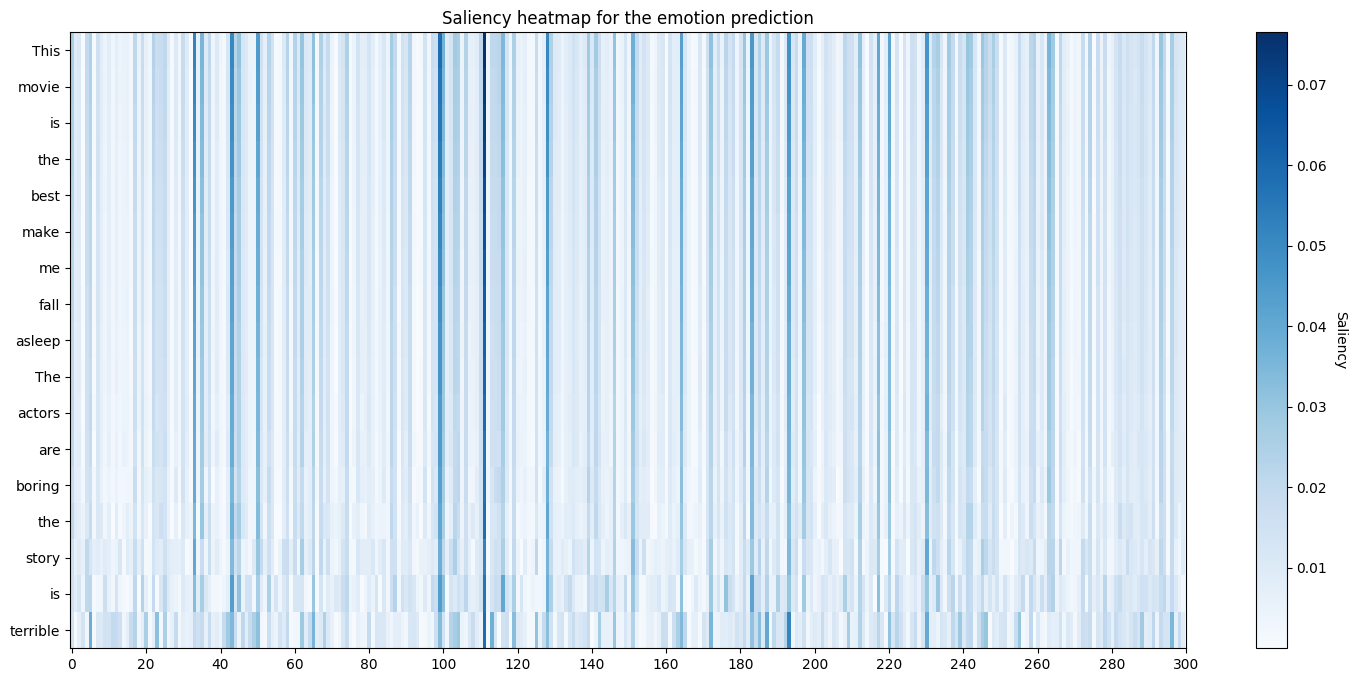

In [81]:
plot_sailency_map(saliency_list, sentence)

In [82]:
# find the norm of each element in the saliency list
saliency_list_module = np.linalg.norm(saliency_list, axis=1)
# add a second empty dimension to the saliency list module
saliency_list_module = np.expand_dims(saliency_list_module, axis=1)

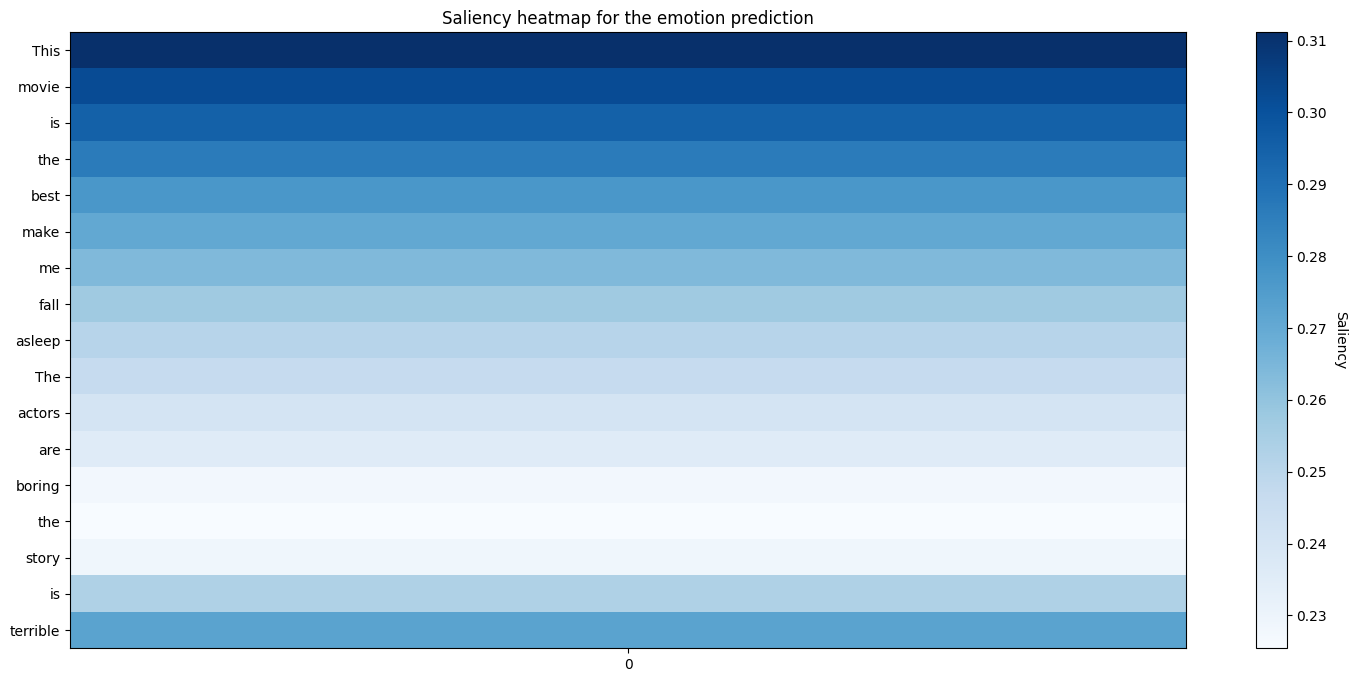

In [83]:
plot_sailency_map(saliency_list_module, sentence)

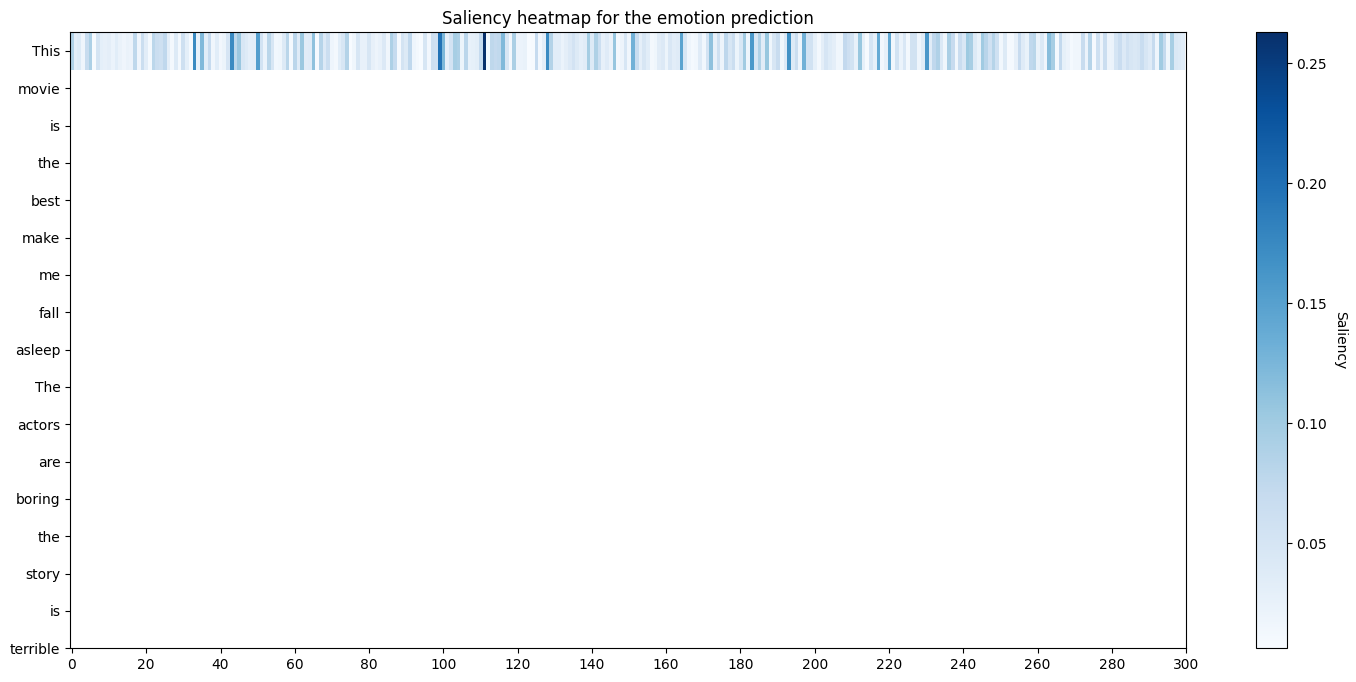

In [84]:
saliency_list_embedding = np.linalg.norm(saliency_list, axis=0)
saliency_list_embedding = np.expand_dims(saliency_list_embedding, axis=0)
plot_sailency_map(saliency_list_embedding, sentence)